# Un Modelo Básico de AMPL

AMPL es un lenguaje de modelado algebraico para la optimización matemática que se integra con el entorno de programación Python. Permite a los usuarios definir modelos de optimización que consisten en variables de decisión, funciones objetivo y restricciones, y calcular soluciones utilizando una variedad de solvers de código abierto y comerciales.

Este cuaderno introduce los conceptos básicos de AMPL necesarios para formular y resolver el [problema de planificación de producción] introducido en el cuaderno anterior:

* Variables
* Objetivos
* Restricciones
* Resolución
* Reporte de la solución

El modelo de AMPL mostrado en este cuaderno es una traducción directa del modelo matemático en componentes básicos de AMPL. En este enfoque, los valores de los parámetros del modelo matemático se incluyen directamente en el modelo de AMPL para mayor simplicidad. 


## Paso Preliminar: Instalar AMPL y herramientas de Python

Comenzamos instalando amplpy, la interfaz de programación de aplicaciones (o API) que integra el lenguaje de modelado AMPL con el lenguaje de programación Python. También instalamos dos utilidades de Python, matplotlib y pandas, que se utilizarán en las partes de este cuaderno que muestran resultados.

Estas instalaciones deben realizarse solo una vez para cada entorno de Python en una computadora personal. Sin embargo, se debe realizar una nueva instalación para cada nueva sesión de Colab.


In [1]:
# instalar dependencias
%pip install -q amplpy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Install solver modules (e.g., HiGHS, CBC, Gurobi)
# amplpy.modules install highs cbc gurobi

In [4]:
# Import and instantiate AMPL object in Python:

from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["cbc", "highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics


## Paso 1. Importar AMPL

El primer paso para un nuevo modelo de AMPL es importar los componentes necesarios en el entorno de AMPL. El código de Python que se muestra a continuación se utiliza al comienzo de cada cuaderno. Hay solo dos elementos que pueden variar según sus necesidades:

* La lista de `modules` importa las herramientas necesarias. En nuestro caso, necesitamos solo amplpy.
* El nombre del solver. Amplpy admite varios solvers disponibles, pero debe configurarse para utilizar uno de ellos.




## Paso 2. Definir Variables

El siguiente paso es definir las variables del modelo. Esto incluye tanto las variables de decisión como las variables auxiliares utilizadas para cálculos intermedios.



In [5]:
%%ampl_eval
# define decision variables

reset;

var xM >= 0;
var xA >= 0, <= 80;
var xB >= 0, <= 100;

var yU >= 0, <= 40;
var yV >= 0;


## Paso 3. Definir la Función Objetivo

El objetivo del modelo es maximizar las ganancias. Esto se logra definiendo la función objetivo como la diferencia entre los ingresos y los costos.



In [6]:
%%ampl_eval
# define objective function

maximize Profit:
   270*yU + 210*yV - 10*xM - 50*xA - 40*xB;


## Paso 4. Definir las Restricciones

Las restricciones se derivan de los recursos disponibles y los requisitos de los productos. Las restricciones se pueden escribir como:


In [8]:
%%ampl_eval
# define constraints

subj to raw_materials: 10*yU + 9*yV <= xM;
subj to labor_A: 2*yU + 1*yV <= xA;
subj to labor_B: 1*yU + 1*yV <= xB;


### Paso 5: Resolver el problema

Con el modelo completamente especificado, el siguiente paso es calcular los valores óptimos para las variables de decisión. Para esto, usaremos comandos y llamadas a funciones de `amplpy` que gestionan la integración de AMPL y Python.

Para calcular una solución óptima, llamamos a un **solver**: un programa separado que aplica algoritmos numéricos para determinar valores óptimos para las variables. Los pasos son los siguientes:

1. **Mostrar y expandir los componentes del modelo**:
   - Utiliza los comandos `show` y `expand` en AMPL para verificar que todo ha sido especificado correctamente.
   - Usa la función `eval` de `amplpy.AMPL` para ejecutar estos comandos en AMPL desde Python.

2. **Configurar el solver**:
   - La opción `solver` de `amplpy.AMPL` se establece en uno de los solvers que cargamos en el paso 2.

3. **Invocar el solver**:
   - La función `solve` de `amplpy.AMPL` invoca el solver elegido. AMPL se encarga de convertir el modelo a la forma que el solver necesita para su cálculo, y convierte los resultados a un formato que puede ser usado en Python.



In [9]:
# exhibit the model that has been built
ampl.eval("show;")
ampl.eval("expand;")

# solve using two different solvers
ampl.option["solver"] = "cbc"
ampl.solve()

ampl.option["solver"] = "highs"
ampl.solve()


variables:   xA   xB   xM   yU   yV

constraints:   labor_A   labor_B   raw_materials

objective:   Profit
maximize Profit:
	-10*xM - 50*xA - 40*xB + 270*yU + 210*yV;

subject to raw_materials:
	-xM + 10*yU + 9*yV <= 0;

subject to labor_A:
	-xA + 2*yU + yV <= 0;

subject to labor_B:
	-xB + yU + yV <= 0;

cbc 2.10.10:cbc 2.10.10: optimal solution; objective 2400
0 simplex iterations
HiGHS 1.7.0:HiGHS 1.7.0: optimal solution; objective 2400
0 simplex iterations
0 barrier iterations


## Paso 6. Reportando la solución

El paso final en la mayoría de las aplicaciones es reportar la solución en un formato adecuado. Para este ejemplo, demostramos informes simples en formato tabular y gráfico utilizando la biblioteca Pandas. 

### Accediendo a los valores de la solución con `display`

La función `ampl.display` de `amplpy` muestra los valores de una o más expresiones de AMPL, calculados a partir de los valores actuales de las variables. También puedes aplicar esta función a expresiones especiales como `_var` para los valores de todas las variables y `_varname` para los nombres de todas las variables.

In [10]:
# display a component of the model
ampl.display("Profit")
ampl.display("270*yU + 210*yV", "10*xM + 50*xA + 40*xB")

ampl.display("_varname", "_var")

Profit = 2400

270*yU + 210*yV = 16800
10*xM + 50*xA + 40*xB = 14400

: _varname  _var    :=
1   xM       720
2   xA        80
3   xB        80
4   yU         0
5   yV        80
;



### Accediendo a los valores de la solución con `get_value`

Después de que una solución óptima ha sido calculada exitosamente, el valor de una expresión de AMPL puede ser recuperado en Python usando la función `ampl.get_value`. Cuando se combina con las cadenas `f` de Python, `ampl.get_value` proporciona un medio conveniente para crear informes formateados.

In [11]:
print(f" Profit = {ampl.get_value('Profit'): 9.2f}")
print(f"Revenue = {ampl.get_value('270*yU + 210*yV'): 9.2f}")
print(f"   Cost = {ampl.get_value('10*xM + 50*xA + 40*xB'): 9.2f}")

 Profit =   2400.00
Revenue =  16800.00
   Cost =  14400.00



### Crear reportes con Pandas y Matplotlib

Pandas, una biblioteca de código abierto para trabajar con datos en Python, es ampliamente utilizada en la comunidad de ciencia de datos. Aquí utilizamos un objeto `Series()` de Pandas para mantener y mostrar datos de la solución. Luego podemos visualizar los datos utilizando la biblioteca matplotlib, por ejemplo, con un gráfico de barras.



In [12]:
import pandas as pd

# create pandas series for production and raw materials
production = pd.Series(
    {
        "U": ampl.get_value("yU"),
        "V": ampl.get_value("yV"),
    }
)

raw_materials = pd.Series(
    {
        "A": ampl.get_value("xA"),
        "B": ampl.get_value("xB"),
        "M": ampl.get_value("xM"),
    }
)

# display pandas series
display(production)
display(raw_materials)

U     0
V    80
dtype: int64

A     80
B     80
M    720
dtype: int64

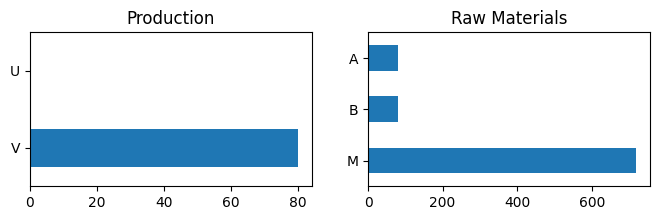

In [13]:
import matplotlib.pyplot as plt

# create grid of subplots
fig, ax = plt.subplots(1, 2, figsize=(8, 2))

# show pandas series as horizontal bar plots
production.plot(ax=ax[0], kind="barh", title="Production")
raw_materials.plot(ax=ax[1], kind="barh", title="Raw Materials")

# show vertical axis in descending order
ax[0].invert_yaxis()
ax[1].invert_yaxis()

In [14]:
%%writefile production_planning_basic.mod

# decision variables
var x_M >= 0;
var x_A >= 0, <= 80;
var x_B >= 0, <= 100;

var y_U >= 0, <= 40;
var y_V >= 0;

# auxiliary variables
var revenue = 270 * y_U + 210 * y_V;
var cost = 10 * x_M + 50 * x_A + 40 * x_B;

# objective
maximize profit: revenue - cost;

# constraints
s.t. raw_materials: 10 * y_U + 9 * y_V <= x_M;
s.t. labor_A: 2 * y_U + 1 * y_V <= x_A;
s.t. labor_B: 1 * y_U + 1 * y_V <= x_B;

Writing production_planning_basic.mod


In [16]:
# Create AMPL instance and load the model
ampl = AMPL()
ampl.read("production_planning_basic.mod")

# Select a solver and solve the problem
ampl.option["solver"] = "cbc"
ampl.solve()

cbc 2.10.10:cbc 2.10.10: optimal solution; objective 2400
0 simplex iterations
